# Some Common Tensor Operations

### But not necessarily intuitive

A short introduction about PyTorch and about the chosen functions. 
- Tensor.permute
- Tensor.transpose
- torch.stack
- tensor.unsqueeze
- 

In [2]:
# Import torch and other required modules
import torch
from PIL import Image
import numpy as np
import cv2

## Tensor.permute(*dims)

This function is very useful because Pytorch has a different ordering of dimensions than some common source of data like `cv2` or `PIL` images or the numpy arrays we use to represent images. But this is only one use. During the various operations in a Feedforward Network, one tensor operation output is an input to another one and this can repeat dozens or even hundreds for modern networks, so it's imperative to use this function enough to make it second nature.

To ilustrate its use, let's use images just for fun.

In [4]:
# Credit: https://www.sciencealert.com/can-you-catch-covid-19-from-your-pets-here-s-the-science
pil_image = Image.open('images/cat.jpg')

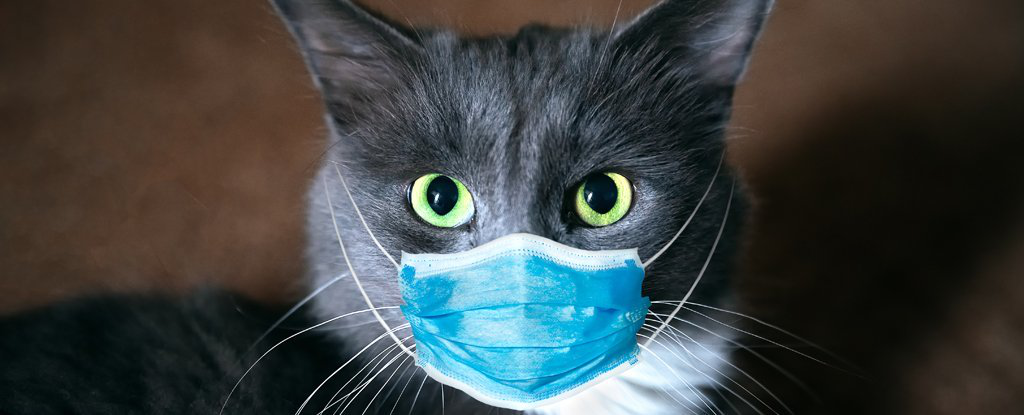

In [5]:
pil_image

In [6]:
pil_image.size

(1024, 415)

By looking at the image, we can see that in `PIL` the dimensions are alocated as `width x height x channels`. We cannot see the channels ( 3 colors in an image ) in this format with PIL, but the third dimension is for the channels.

In [7]:
opencv_image = cv2.imread('images/cat.jpg')

In [8]:
opencv_image.shape

(415, 1024, 3)

With `opencv` the dimensions are `height x width x channels`. The data type is already a `numpy.ndarray`. For `PIL` we must convert it.

In [9]:
pil_array = np.asarray(pil_image)

In [10]:
pil_array.shape

(415, 1024, 3)

If we turn our `PIL` array into a tensor

In [11]:
pil_tensor = torch.as_tensor(pil_array)

/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


In [12]:
pil_tensor.shape

torch.Size([415, 1024, 3])

But in Pytorch, images dimensions are `channels x height x width`, so this direct conversion will lead to errors or spurious results. To fix this we should put the third dimension into the first one and slide to the right the other two. We accomplish this with the following:

In [13]:
pil_tensor = pil_tensor.permute(2, 0, 1)

In [14]:
pil_tensor.shape

torch.Size([3, 415, 1024])

In [15]:
pil_tensor.numpy().shape

(3, 415, 1024)

To recover our image into something `PIL` can show we have to revert the process

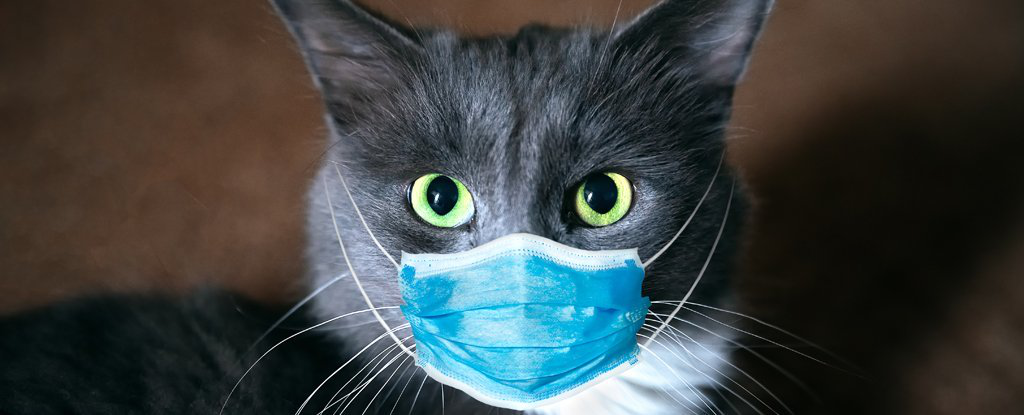

In [16]:
Image.fromarray(pil_tensor.permute(1, 2, 0).numpy())

Let's try to visualize our `opencv` image:

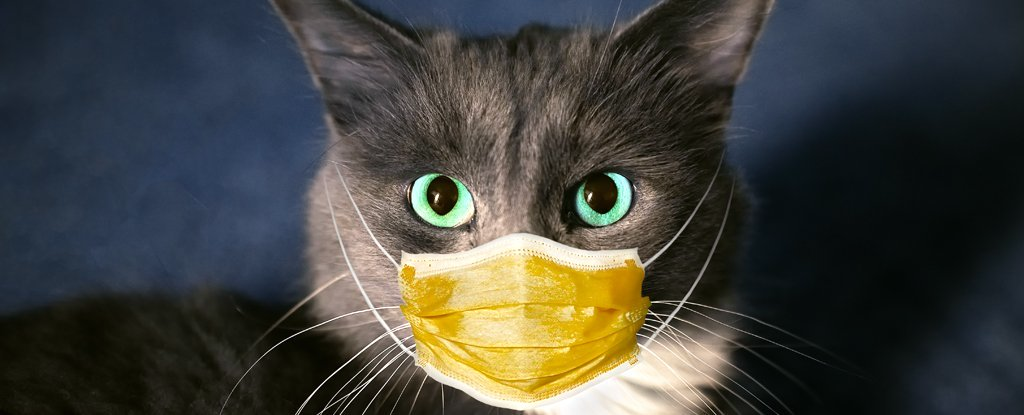

In [17]:
Image.fromarray(opencv_image)

We can see that the colors are not right, the gradient is changed and the mask which was blue is now more of a golden yellow. That happened because the channels in `opencv` are in the order `Blue, Green and Red` while in `PIL` the channels are ordered `Red, Green and Blue`. So we see that swapping the Red and Blue colors gave that effect. So if we had to read the different images in Pytorch we would have different tensors. To fix this we should swap these rows in the channels dimension.

Save the row `0` of the channel dimension.

In [18]:
copy_cv_image = opencv_image.copy()

Copy row `2` to row `0`

In [19]:
copy_cv_image[:, :, 0] = opencv_image[:, :, 2].copy()

Copy row `0` to row `2`

In [20]:
copy_cv_image[:, :, 2] = opencv_image[:, :, 0].copy()

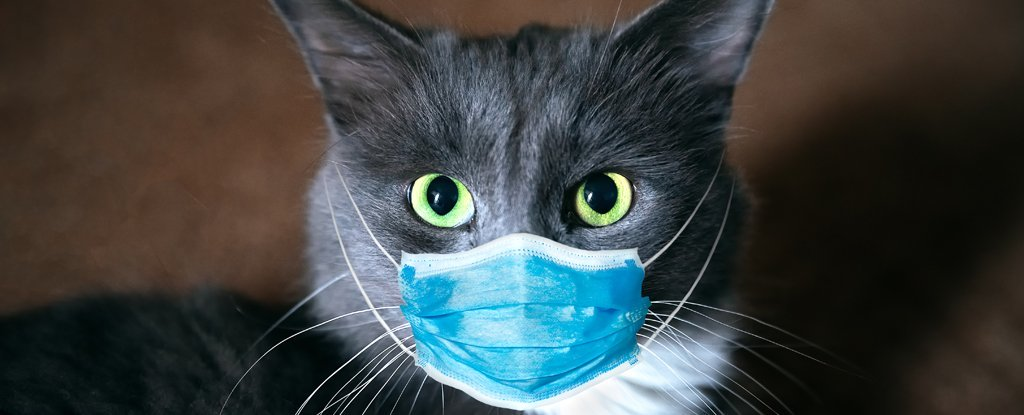

In [21]:
Image.fromarray(copy_cv_image)

But of course there is a method for that:

In [22]:
opencv_image = cv2.cvtColor(opencv_image, cv2.COLOR_BGR2RGB)

## Tensor.transpose()
This is also a very common function, used to switch 2 dimensions in tensors.

In [24]:
t1 = torch.randn(4,3,2)

In [26]:
t1.shape

torch.Size([4, 3, 2])

When using transpose, you just inform the indexes to switch. The order doesn't matter

In [31]:
t1.transpose(1, 0).shape

torch.Size([3, 4, 2])

The following performs the same

In [30]:
t1.transpose(0,1).shape

torch.Size([3, 4, 2])

For tensors of only 2 dimensions or less, there is an alias without arguments

In [33]:
t2 = torch.randn(3,2) ; t2

tensor([[-0.5672,  1.2918],
        [-1.5242, -0.0775],
        [-0.5895,  1.3932]])

In [34]:
t2.t()

tensor([[-0.5672, -1.5242, -0.5895],
        [ 1.2918, -0.0775,  1.3932]])

## torch.stack
We often need to stack a series of tensors in a single one. For example in training, we don't normally provide one train example at a time but a bunch of them, in a `mini-batch`. In simple terms, stacking `n` individual tensors of rank `m` creates a tensor of rank `m+1` with `n` items in the additional dimension created.

In [35]:
list_tensors = [torch.randn(2,2) for _ in range(1024)]

Suppose we have a batch size of 32, i.e. we will pass to our model 32 stacked tensors at a time.

In [36]:
batch_size = 32
batch_list = [torch.stack(list_tensors[i:i+batch_size]) for i in range(1024 // 32)]

In [37]:
len(batch_list)

32

We have 32 batch_tensors, each with 32 input tensors of shape 2x2

In [38]:
batch_list[0].shape

torch.Size([32, 2, 2])

## torch.unsqueeze
The same way we created a new tensor with an additional dimension by stacking other tensors. Sometimes we need to create an additional dimension in a current tensor without having tensors to stack, this is usually to adjust dimensions in calculations or to allow broadcasting.

In [39]:
a = torch.randn(3,4)
b = torch.randn(4,2)

In [40]:
c = torch.zeros(3,2)

Departing from the basic definition of matrix multiplication towards a more efficient and vectorized definition.

In [42]:
for i in range(a.shape[0]):
    for j in range(b.shape[1]):
        for k in range(a.shape[1]): # or b.shape[0]
            c[i,j] += a[i,k] * b[k,j]

In [43]:
c

tensor([[-0.7953,  0.9912],
        [-2.1986, -0.6580],
        [-3.8281, -0.7769]])

Eliminating the third loop.

In [44]:
c = torch.zeros(3,2)
for i in range(a.shape[0]):
    for j in range(b.shape[1]):
        c[i,j] = (a[i,:] * b[:,j]).sum()

In [45]:
c

tensor([[-0.7953,  0.9912],
        [-2.1986, -0.6580],
        [-3.8281, -0.7769]])

When trying to eliminate the second loop, let's just eliminate the index and see what happens.

In [46]:
c = torch.zeros(3,2)
for i in range(a.shape[0]):
    c[i,j] = (a[i] * b).sum()

RuntimeError: The size of tensor a (4) must match the size of tensor b (2) at non-singleton dimension 1

We have a broadcasting mismatch, since b is a matrix `4x2` and `a[i,:]` has shape 3. We need to create and additional dimension in a, with value `1` to allow broadcasting

In [76]:
c = torch.zeros(3,2)
for i in range(a.shape[0]):
    c[i] = (a[i].unsqueeze(dim=1) * b).sum(dim=0)

Of course in practice we use the optimized Pytorch implementation

In [79]:
c

tensor([[-0.7953,  0.9912],
        [-2.1986, -0.6580],
        [-3.8281, -0.7769]])

In [78]:
a @ b

tensor([[-0.7953,  0.9912],
        [-2.1986, -0.6580],
        [-3.8281, -0.7769]])

## tensor.view
This method changes the dimension of a tensor without changing its contents. This is also a common procedure to move along our inputs or weights across our model or to adjust the format to perform operations.

In [80]:
t1 = torch.randn(4,4,4)

In [82]:
t1.view(8, 8)

tensor([[ 0.7817,  0.4861, -1.4196,  1.2048, -0.7579, -0.0910,  0.7978, -0.9830],
        [-2.0448, -0.2591,  0.6421, -0.3539,  0.2657,  1.0216,  1.0016, -0.2136],
        [-1.9065,  0.3931, -1.8919, -1.8955,  0.1288,  0.1466,  0.8893,  1.4217],
        [ 0.3813,  0.0620, -0.0212, -0.3475,  0.3033,  0.9232,  1.1302,  0.2031],
        [-0.8675,  1.0729,  1.2916,  0.6765, -1.9075, -0.7634, -1.9011, -1.3743],
        [ 0.8663,  1.0154,  1.0144,  0.2806, -0.5309, -0.1084,  1.8375, -0.3879],
        [-0.0332,  0.6689, -0.0597,  0.9262, -0.2651, -0.3076,  0.8460, -1.0171],
        [-0.3516,  1.6240,  2.0473,  0.5753,  0.4684, -0.0091, -0.9797,  0.6781]])

In [86]:
t1.view(-1, 2, 4) 

tensor([[[ 0.7817,  0.4861, -1.4196,  1.2048],
         [-0.7579, -0.0910,  0.7978, -0.9830]],

        [[-2.0448, -0.2591,  0.6421, -0.3539],
         [ 0.2657,  1.0216,  1.0016, -0.2136]],

        [[-1.9065,  0.3931, -1.8919, -1.8955],
         [ 0.1288,  0.1466,  0.8893,  1.4217]],

        [[ 0.3813,  0.0620, -0.0212, -0.3475],
         [ 0.3033,  0.9232,  1.1302,  0.2031]],

        [[-0.8675,  1.0729,  1.2916,  0.6765],
         [-1.9075, -0.7634, -1.9011, -1.3743]],

        [[ 0.8663,  1.0154,  1.0144,  0.2806],
         [-0.5309, -0.1084,  1.8375, -0.3879]],

        [[-0.0332,  0.6689, -0.0597,  0.9262],
         [-0.2651, -0.3076,  0.8460, -1.0171]],

        [[-0.3516,  1.6240,  2.0473,  0.5753],
         [ 0.4684, -0.0091, -0.9797,  0.6781]]])

`-1` is a special parameter which tells Pytorch to adjust the number of values in that dimension accordingly to complete the number of values necessary considering the other.